In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))
import Functions.HMM as HMM
import Functions.kinematics as kinematics
import Functions.patch as patch


import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import SSM.ssm as ssm
from SSM.ssm.util import find_permutation
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

In [16]:
color_names = ["blue","red","darkorange", "green","black","purple","darkorange", "turquoise", 'tan']

In [19]:
# Processed raw data: maintenance data excluded, nan value interpolated
mouse_pos = pd.read_parquet('mousepos.parquet', engine='pyarrow')
display(mouse_pos)

,x,y,filtered_position_x,filtered_position_y,filtered_velocity_x,filtered_velocity_y,filtered_acceleration_x,filtered_acceleration_y,smoothed_position_x,smoothed_position_y,smoothed_velocity_x,smoothed_velocity_y,smoothed_acceleration_x,smoothed_acceleration_y,smoothed_speed,smoothed_acceleration
time,,,,,,,,,,,,,,,,
2022-08-15 13:11:30.051296234,237.836426,531.666687,237.829709,531.657690,0.102785,0.587669,0.553673,1.543887,238.050332,531.960782,2.387246,7.745330,114.768281,359.236470,8.104880,377.124117
2022-08-15 13:11:30.071328163,238.111542,532.057739,237.982273,531.891373,1.593067,4.486184,42.815478,112.023049,238.127711,532.210361,5.350734,17.212558,148.174413,473.361412,18.025053,496.010769
2022-08-15 13:11:30.091296196,238.459061,532.976929,238.272732,532.662194,10.243183,31.701830,199.748503,618.333911,238.258487,532.633460,7.726831,25.097328,118.804853,394.238480,26.259851,411.750619
2022-08-15 13:11:30.111328125,238.480743,533.356445,238.491931,533.371544,13.379086,42.335027,185.857466,589.076910,238.425833,533.184975,9.007748,30.054202,64.045820,247.843695,31.375063,255.985086
2022-08-15 13:11:30.131296158,238.517136,533.782959,238.594819,533.916195,10.895791,40.155776,94.134080,359.237494,238.607230,533.811753,9.131985,32.623583,6.211870,128.469050,33.877593,128.619144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15 16:01:44.127168178,243.603149,520.372925,243.550329,520.184904,-40.161556,95.126141,-169.686206,-682.827866,243.489848,520.506842,-46.811486,106.361583,-371.375069,-528.494617,116.207149,645.930338
2022-08-15 16:01:44.147136211,242.608215,522.574097,242.637712,522.424665,-45.871962,97.701467,-205.253499,-404.786309,242.466036,522.501959,-55.569678,93.150126,-437.909620,-660.572828,108.466286,792.541038
2022-08-15 16:01:44.167168140,241.278580,524.524597,241.391188,524.470203,-58.821244,95.514220,-341.035949,-303.577917,241.258971,524.198283,-65.136865,76.482293,-478.359344,-833.391658,100.460701,960.921077


In [28]:
title = 'ShortSession'+str(8)  
mouse_pos = pd.read_parquet('../Data/MousePos/' + title + 'mousepos.parquet', engine='pyarrow')

feature = ['smoothed_speed', 'smoothed_acceleration']
obs = np.array(mouse_pos[feature])
hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = N, n_iters = 50)
    
state_mean_speed = hmm.observations.params[0].T[0]
index = np.argsort(state_mean_speed, -1)   

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

In [49]:
speed_index = np.argsort(hmm.observations.params[0].T[0], -1)   
mean_speed, mean_acce = hmm.observations.params[0].T[0][speed_index], hmm.observations.params[0].T[1][speed_index]
var_speed, var_acce = hmm.observations.params[1][speed_index][:,0,0], hmm.observations.params[1][speed_index][:,1,1]

In [141]:
states = np.load('../Figures/Results/States.npy', allow_pickle=True)
mouse_pos = pd.read_parquet('../Data/MousePos/' + 'ShortSession1' + 'mousepos.parquet', engine='pyarrow')

In [123]:
feature = ['smoothed_speed', 'smoothed_acceleration']
obs = np.array(mouse_pos[feature])

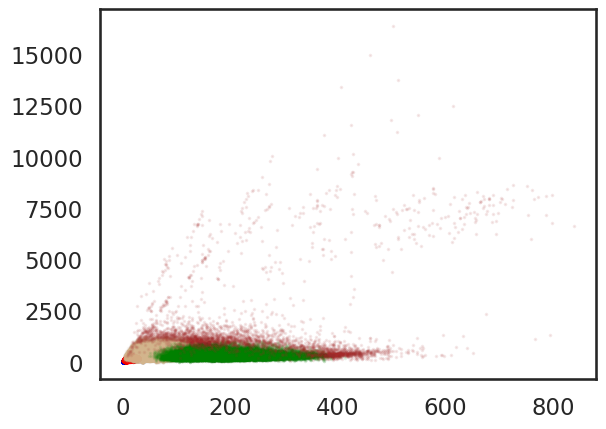

In [124]:
color_names = ["blue","red","tan", "green","brown","purple","darkorange", "black", 'turquoise']
for i in range(9):
    plt.scatter(obs.T[0][states==i], obs.T[1][states==i], alpha = 0.1, s = 1, color = color_names[i])
plt.show()

In [142]:
mouse_pos['states'] = pd.Series(states, index = mouse_pos.index)
max(states)

5

In [156]:
x1 = np.array([1,1,0,0,0])
x2 = np.array([0,0,0,0,1])

z = x1 + x2
z

array([1, 1, 0, 0, 1])

In [172]:
def PositionInPatch(mouse_pos, r = 30):
    Patch1, Patch2 = [554,832],[590.25, 256.75]
    
    # Calculate distances
    distance1 = np.sqrt((mouse_pos['smoothed_position_x'] - Patch1[0]) ** 2 + (mouse_pos['smoothed_position_y'] - Patch1[1]) ** 2)
    distance2 = np.sqrt((mouse_pos['smoothed_position_x'] - Patch2[0]) ** 2 + (mouse_pos['smoothed_position_y'] - Patch2[1]) ** 2)
    
    # Calssify
    mouse_pos['Patch'] = np.where(distance1 < r, 1, 0) + np.where(distance2 < r, 1, 0)
    
    return mouse_pos

mouse_pos = PositionInPatch(mouse_pos, r = 30)
count = 0
for i in range(len(mouse_pos)):
    if mouse_pos.states[i] == 0:
        if mouse_pos.Patch1[i] == 1 or mouse_pos.Patch2[i] == 1: count += 1

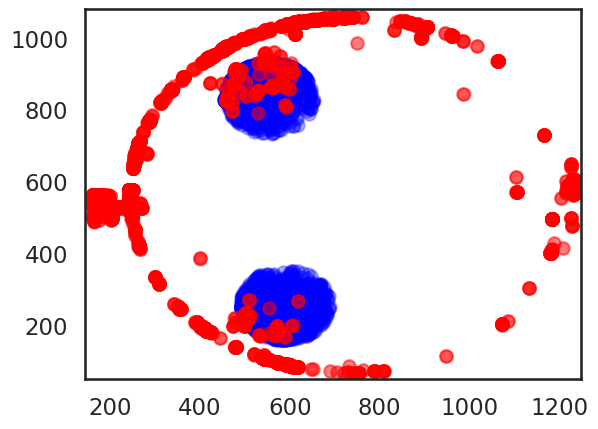

In [181]:

mouse_pos = PositionInPatch(mouse_pos, r = 100)
x = mouse_pos.smoothed_position_x.to_numpy()
y = mouse_pos.smoothed_position_y.to_numpy()
plt.scatter(x[mouse_pos.Patch == 1],y[mouse_pos.Patch == 1], color = 'blue', alpha = 0.3)
plt.scatter(x[states == 0],y[states == 0], color = 'red', alpha = 0.3)
plt.xlim(145, 1250)
plt.ylim(50, 1080)
plt.show()

In [171]:
sum(states==0)

12719

In [134]:
n=6
mouse_pos = GetStates(1, n, denoise=True)
states = mouse_pos['states'].to_numpy()
start = dict()
for key in range(n): start[key] = np.zeros((n))

for i in range(len(states)-1):
    start[states[i]][states[i+1]] += 1
    
TransM = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        TransM[i][j] = start[i][j]/sum(start[i])

/tmp/ipykernel_1404362/273783212.py:14: RuntimeWarning: invalid value encountered in double_scalars
  TransM[i][j] = start[i][j]/sum(start[i])


In [131]:
def GetStates(id, n, denoise = True):
    title = 'ShortSession' + str(id)
    mouse_pos = pd.read_parquet('../Data/MousePos/' + title + 'mousepos.parquet', engine='pyarrow')
    states = np.load('../Figures/Results/States.npy', allow_pickle=True)
    mouse_pos['states'] = pd.Series(states, index = mouse_pos.index)
    
    if denoise:
        resampled_mouse_pos = mouse_pos.resample('1S').agg({
        'x': 'mean',  
        'y': 'mean',  
        'smoothed_velocity_x':'mean',
        'smoothed_position_x':'mean',
        'smoothed_position_y':'mean',
        'smoothed_speed':'mean',
        'smoothed_acceleration':'mean',
        'states': lambda x: x.mode()[0] if not x.empty else None  # Most frequent value in 'states'
        })
    
        return resampled_mouse_pos
    else: 
        return mouse_pos

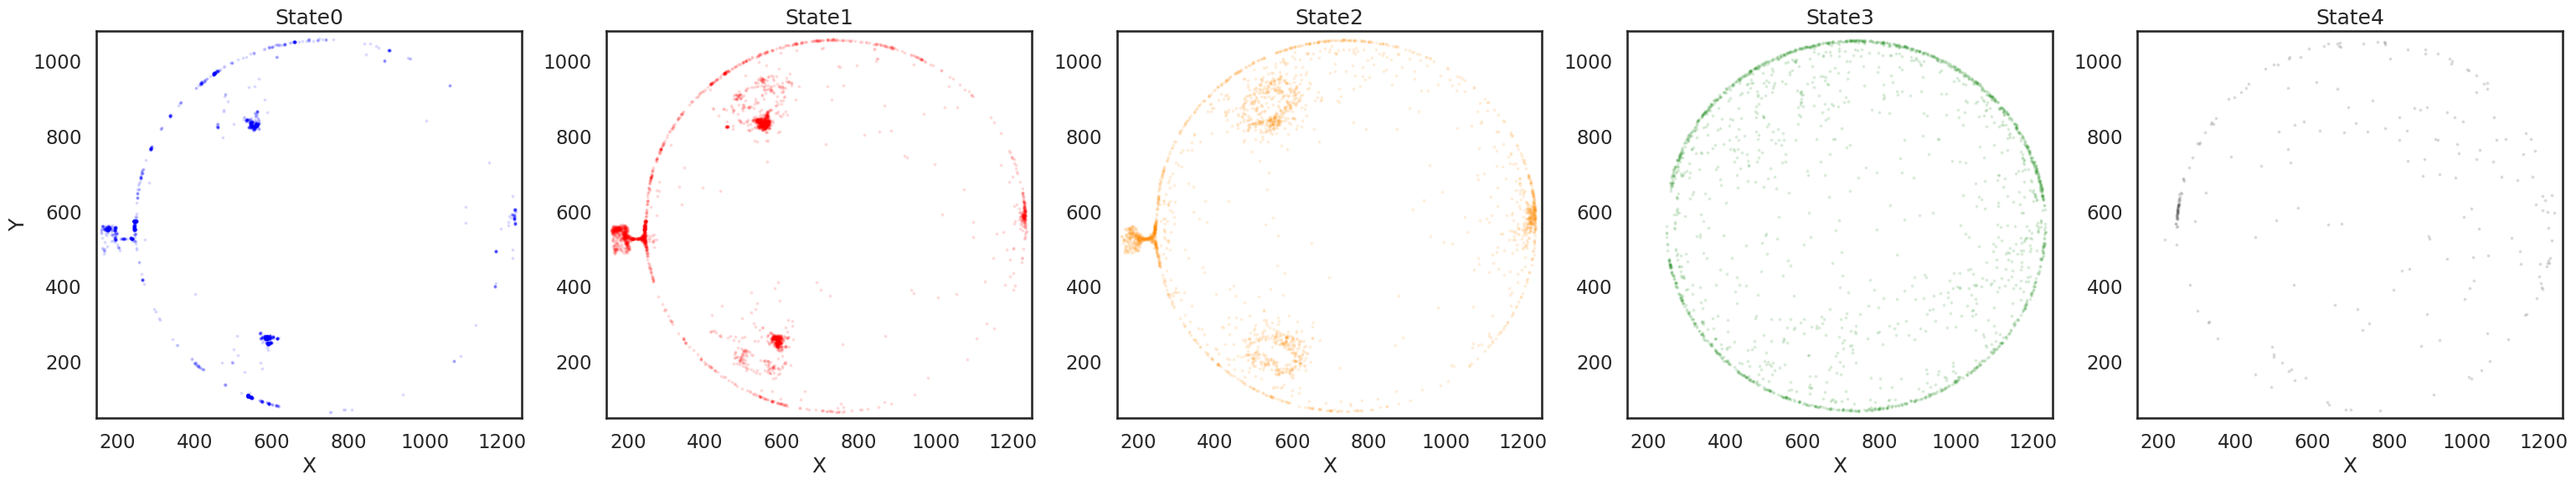

In [111]:
mouse_pos = GetStates(id = 1, n=5, denoise=True)
n=5
x = mouse_pos['smoothed_position_x'].to_numpy()
y = mouse_pos['smoothed_position_y'].to_numpy()
states = mouse_pos['states'].to_numpy()

fig, axs = plt.subplots(1, n, figsize = (n*8-2,6))
for i in range(n):
    X, Y = x[states == i], y[states == i]
    axs[i].scatter(X, Y, color = color_names[i], s = 2, alpha = 0.1)
    axs[i].set_xlim(145, 1250)
    axs[i].set_ylim(50, 1080)
    axs[i].set_title('State' + str(i))
    axs[i].set_xlabel('X')
axs[0].set_ylabel('Y')
plt.show()

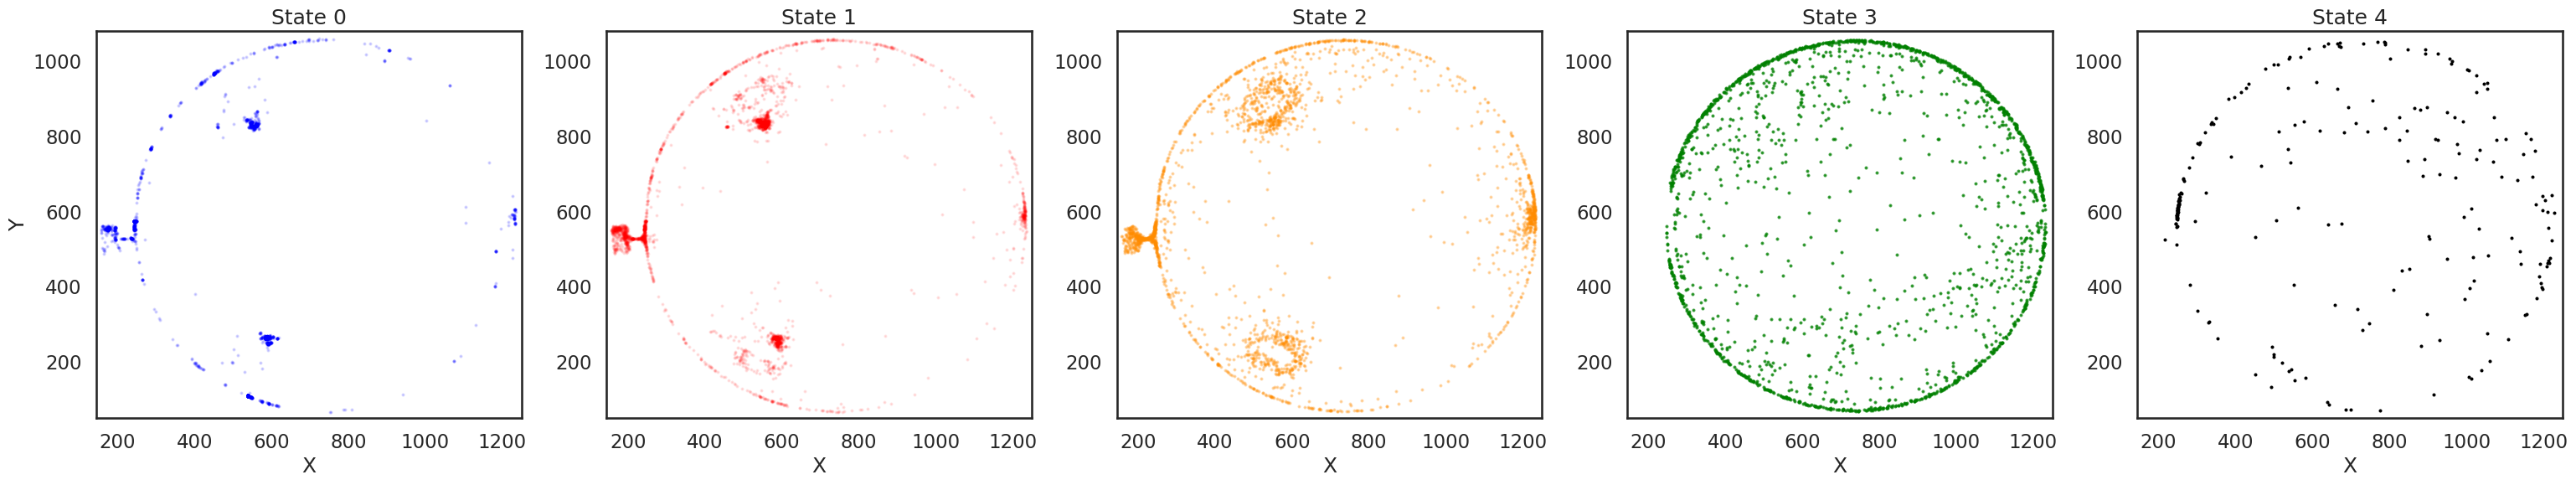

In [115]:
alpha = [0.15, 0.1, 0.3, 0.7, 1]
fig, axs = plt.subplots(1, n, figsize = (n*8-2,6))
for i in range(n):
    X, Y = x[states == i], y[states == i]
    axs[i].scatter(X, Y, color = color_names[i], s = 2, alpha = alpha[i])
    axs[i].set_xlim(145, 1250)
    axs[i].set_ylim(50, 1080)
    axs[i].set_title('State ' + str(i))
    axs[i].set_xlabel('X')
axs[0].set_ylabel('Y')
plt.show()

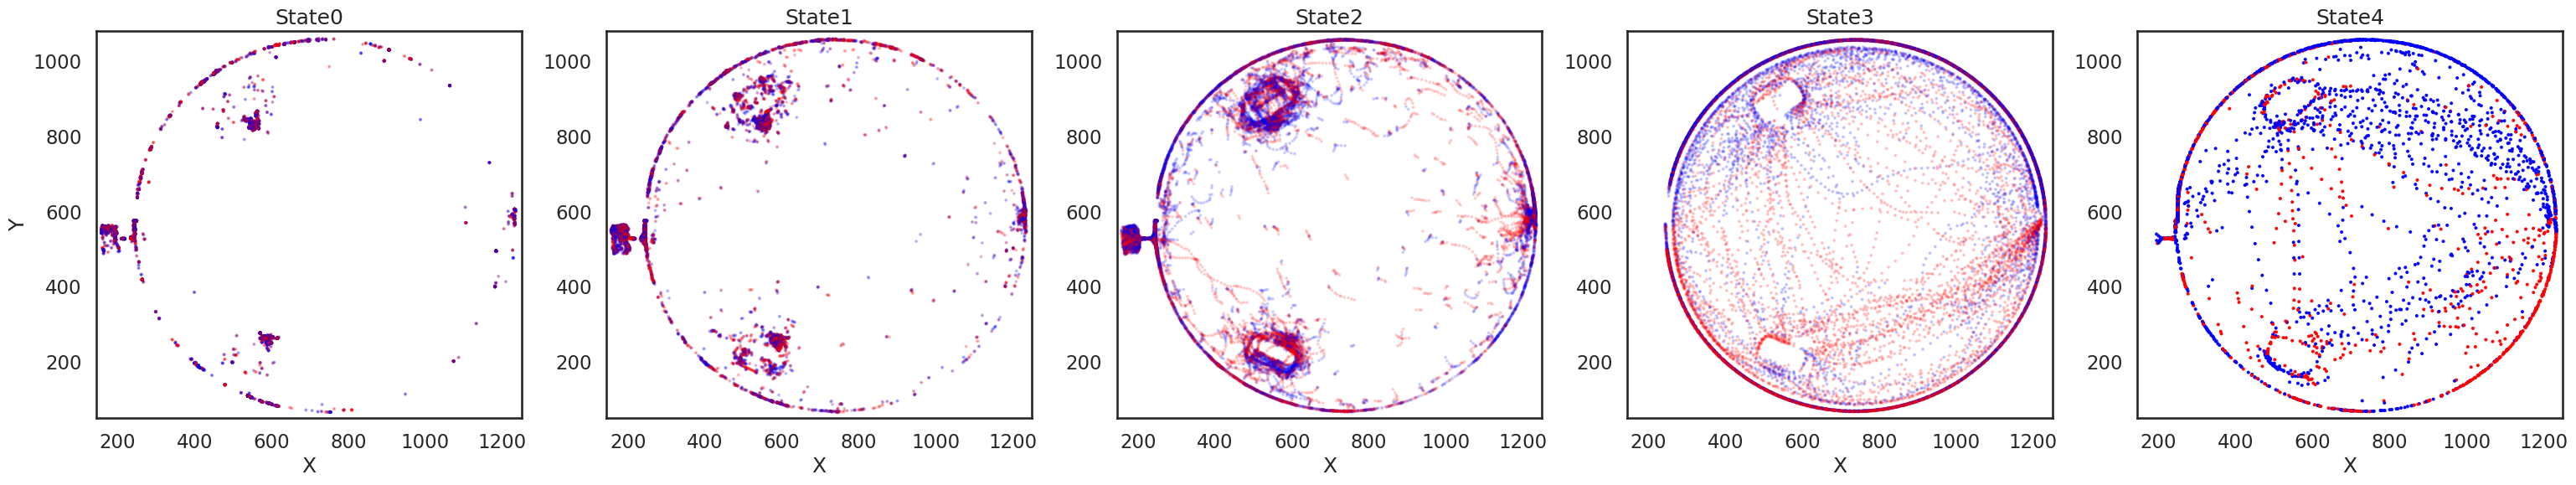

In [56]:
n=5
x = mouse_pos['smoothed_position_x'].to_numpy()
y = mouse_pos['smoothed_position_y'].to_numpy()
X_vel = mouse_pos['smoothed_velocity_x'].to_numpy()
flag = X_vel > 0

fig, axs = plt.subplots(1, n, figsize = (n*8-2,6))
for i in range(n):
    X, Y = x[states == i], y[states == i]
    x_vel_dir = flag[states == i]
    colors = ['blue' if j else 'red' for j in x_vel_dir]
    axs[i].scatter(X, Y, color = colors, s = 2, alpha = 0.033 * len(x)/len(x[states == i]))
    axs[i].set_xlim(145, 1250)
    axs[i].set_ylim(50, 1080)
    axs[i].set_title('State' + str(i))
    axs[i].set_xlabel('X')
axs[0].set_ylabel('Y')
plt.show()

# Blue: go right
# Red: go left

In [110]:
np.log10(1 + 0.6*3e3/len(x[states == 2]))

0.2514712162231572

In [108]:
0.6 * 3e3/len(x[states == 2])

0.7843137254901961

In [83]:
0.07*3e3/len(x[states == 4])

0.9417040358744396

In [25]:
N = 5
grouped = mouse_pos.groupby([pd.Grouper(freq='1S'), 'states']).size()
prob = grouped.groupby(level=0).apply(lambda g: g / g.sum())
states_prob = prob.unstack(level=-1).fillna(0)
states_prob.index = states_prob.index.get_level_values(0)

for i in range(N):
    if i not in states_prob.columns: states_prob[i] = 0
    #states_prob.iloc[0, states_prob.columns.get_loc(i)] = 1e-5

x = np.array([np.array(states_prob[i].to_list()) for i in range(N)])

states_ = []
for i in range(len(x[0])):
    current_state = x.T[i]
    states_.append(np.argmax(current_state))

In [32]:
resampled_df = mouse_pos.resample('1S').agg({
    'x': 'mean',  # Averages the 'x' column
    'y': 'mean',  # Averages the 'y' column
    'states': lambda x: x.mode()[0] if not x.empty else None  # Most frequent value in 'states'
})

In [51]:
start = dict()
for key in range(n): start[key] = np.zeros((n))

for i in range(len(states)-1):
    start[states[i]][states[i+1]] += 1
    
TransM = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        TransM[i][j] = start[i][j]/sum(start[i])

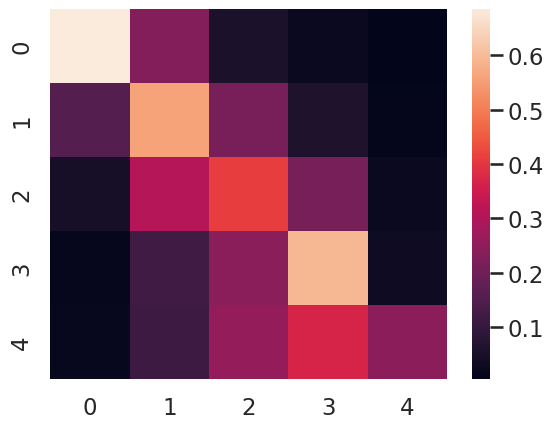

In [52]:
sns.heatmap(TransM)
plt.show()

In [50]:
states = resampled_df['states']
x = resampled_df['x']
0.033 * len(x)/len(x[states == 0])

0.158390327308256

In [9]:
flag = X_vel < 0
x_vel_dir = flag[states == 4]
colors = 

array([ True, False, False, ...,  True,  True,  True])

In [15]:
Visits_Patch1 = pd.read_parquet('../Data/RegressionPatchVisits/' + title + 'Visit1.parquet', engine='pyarrow')
Visits_Patch2 = pd.read_parquet('../Data/RegressionPatchVisits/' + title + 'Visit2.parquet', engine='pyarrow')

In [16]:
Visits_Patch1

,start,end,distance,duration,speed,acceleration,weight,state,entry,PelletsInLastVisitSelf,PelletsInLastVisitOther,IntervalLastVisit
0,2022-08-15 13:11:30.131999969,2022-08-15 13:11:30.197984219,0.039886,0.065984,23.528488,333.897947,17.828171,1,-7.599360,0,0,0.000000
1,2022-08-15 13:12:54.405983925,2022-08-15 13:14:49.433983803,892.700916,115.027999,251.263965,528.298906,17.828171,4,76.574592,0,0,84.207999
2,2022-08-15 13:15:17.761983871,2022-08-15 13:15:32.915999889,103.846100,15.154016,65.114258,474.337222,17.828171,2,219.930592,9,0,28.328000
3,2022-08-15 13:16:08.331999779,2022-08-15 13:16:42.131999969,336.210818,33.800000,257.143861,528.848782,17.828171,4,20.399231,1,0,35.415999
4,2022-08-15 13:17:10.567999840,2022-08-15 13:18:03.033984184,313.439017,52.465984,108.876818,531.429028,17.828171,2,82.635231,3,0,28.435999
...,...,...,...,...,...,...,...,...,...,...,...,...
63,2022-08-15 15:41:17.239999771,2022-08-15 15:41:55.465983868,193.623203,38.225984,14.897361,187.294137,26.799999,1,424.662111,3,1,13.054015
64,2022-08-15 15:44:35.989984035,2022-08-15 15:44:50.303999901,92.777753,14.314015,97.064764,412.124745,23.274513,1,623.412096,2,1,160.524000
65,2022-08-15 15:49:15.349984169,2022-08-15 15:51:16.545983791,892.972447,121.195999,106.758311,564.070417,32.333534,1,42.867296,1,1,265.045984
66,2022-08-15 15:56:21.300000191,2022-08-15 15:57:38.311999798,487.941517,77.011999,152.895519,487.029354,22.210243,1,4.714816,9,1,304.754016


In [19]:
P = []
for i in range(0,len(Visits_Patch1)):
    start, end = Visits_Patch1.start[i], Visits_Patch1.end[i]
                
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    P.append(len(pellets_patch1))

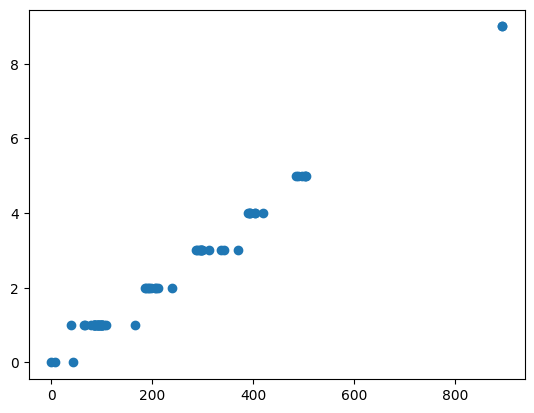

In [20]:
plt.scatter(Visits_Patch1.distance, P)
plt.show()

In [33]:
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Fit the model to the data
model.fit(Visits_Patch1.distance.to_numpy().reshape(-1,1), np.array(P).reshape(-1,1))

slope = model.coef_[0]
intercept = model.intercept_


print(slope, intercept)

[0.00984683] [0.04633095]


In [37]:
x = Visits_Patch1.distance.to_numpy()
x = x // 0.04
x

array([    0., 22317.,  2596.,  8405.,  7835.,   960.,  9247.,  6007.,
        1074., 10480.,  2140.,  2444.,  8554.,  1652.,  1982.,  2341.,
        2257.,  2498.,  7306.,  4959., 12409.,  5144.,  1662.,  5198.,
        2299.,  2503.,  2120.,  2370., 12576.,  2155.,  4158.,   199.,
        5296.,  4800.,  7407.,  2477.,  2161., 12624.,  2130.,  2239.,
        2440., 10101.,  9754., 12126.,  2731.,  2359.,  7203.,  2493.,
        9822.,  7430.,  4667.,  2540.,  4702.,  2502.,  7194.,  7350.,
        9778.,  9833., 10076.,  2115.,  2295.,  7444.,  7476.,  4840.,
        2319., 22324., 12198., 12555.])

In [35]:
max(Visits_Patch1.distance.to_numpy())

892.9724474947889